In [1]:
from lbg_forecast.likelihood import Likelihood
import lbg_forecast.utils as utils

from lbg_forecast.angular_power import define_cosmo
from lbg_forecast.angular_power import pk
import lbg_forecast.angular_power as ap

import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax_cosmo as jc
import pyccl as ccl

In [2]:
path = "./"
lhood = Likelihood(path)

Initialising likelihood
Initialisation Complete


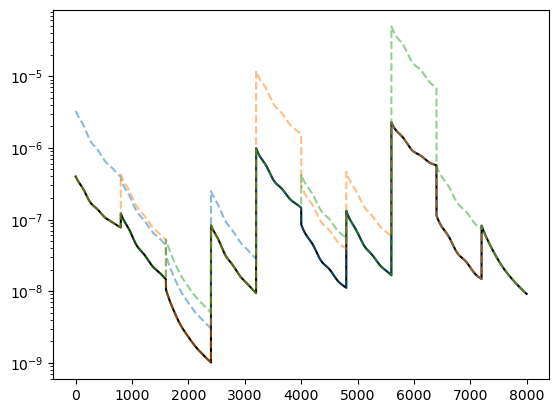

In [3]:
def get_params(du, dg, dr):

    params = np.array([lhood._cosmo_fid.sigma8, 
                    lhood._cosmo_fid.Omega_c, lhood._cosmo_fid.Omega_b,
                    lhood._cosmo_fid.h, lhood._cosmo_fid.n_s,
                    lhood._b_lbg_u+du, lhood._b_lbg_g+dg, lhood._b_lbg_r+dr])

    cosmo_obj = jc.Planck15(sigma8=params[0],
                            Omega_c=params[1],
                            Omega_b=params[2],
                            h=params[3],
                            n_s=params[4])

    bias_params = lhood._bias_params
    bias_params = bias_params.at[0].set(params[5])
    bias_params = bias_params.at[1].set(params[6])
    bias_params = bias_params.at[2].set(params[7])
    nz_params = lhood.nz_params_mean

    return cosmo_obj, nz_params, bias_params

cosmo_obj, nz_params, bias_params = get_params(0, 0, 0)
cl = ap.cl_theory_CMB(cosmo_obj, nz_params, bias_params, lhood._ell, lhood.ndens)

cosmo_obj, nz_params, bias_params = get_params(4, 0, 0)
cl_shift_u = ap.cl_theory_CMB(cosmo_obj, nz_params, bias_params, lhood._ell, lhood.ndens)

cosmo_obj, nz_params, bias_params = get_params(0, 10, 0)
cl_shift_g = ap.cl_theory_CMB(cosmo_obj, nz_params, bias_params, lhood._ell, lhood.ndens)

cosmo_obj, nz_params, bias_params = get_params(0, 0, 20)
cl_shift_r = ap.cl_theory_CMB(cosmo_obj, nz_params, bias_params, lhood._ell, lhood.ndens)

plt.plot(cl, c='k')
plt.plot(cl_shift_u, '--', alpha=0.5)
plt.plot(cl_shift_g, '--', alpha=0.5)
plt.plot(cl_shift_r, '--', alpha=0.5)

plt.yscale('log')

In [4]:
params = np.array([lhood._cosmo_fid.sigma8, 
                    lhood._cosmo_fid.Omega_c, lhood._cosmo_fid.Omega_b,
                    lhood._cosmo_fid.h, lhood._cosmo_fid.n_s,
                    lhood._b_lbg_u, lhood._b_lbg_g, lhood._b_lbg_r])

params

array([0.8159, 0.2589, 0.0486, 0.6774, 0.9667, 2.    , 4.    , 5.    ])

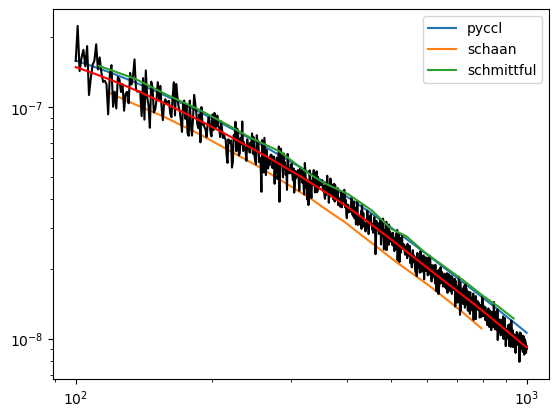

In [5]:
xsch = np.array([117.43977082297401, 132.80159325948537, 155.9618867731977, 188.4317164143467, 256.2266095739562, 332.3231340683669, 365.282054455996, 393.987593415572, 428.9864076105732, 467.0942460883878, 508.5872905486948, 556.3907186959323, 611.5720633631457, 669.0552953100107, 728.4889992084929, 728.4889992084929, 793.2023342284294, 793.2023342284294])
ysch = np.array([0.000013652420392365202, 0.000013843996797624323, 0.000014235252169070247, 0.000014354770953081506, 0.000014038261482177314, 0.000013351397104075012, 0.000012876325185317335, 0.000012592414081133522, 0.00001204323378064385, 0.000011550149481308558, 0.000011046424419380268, 0.000010653368471495614, 0.000010245703975368026, 0.000009771597211815774, 0.000009293492280483563, 0.000009293492280483563, 0.000008789650226937582, 0.000008789650226937582])

cl_shaan = ysch/xsch

cosmo_ccl = ccl.Cosmology(Omega_c=0.2589, Omega_b=0.0486,
                          h=0.6774, n_s=0.9667, sigma8=0.8159)

ell = np.arange(100, 1000, 1)
cmbl = ccl.CMBLensingTracer(cosmo=cosmo_ccl, z_source=1100.0)
acl = ccl.angular_cl(cosmo=cosmo_ccl, tracer1=cmbl, tracer2=cmbl, ell=ell)

plt.plot(ell, acl, label='pyccl')
plt.plot(xsch, cl_shaan, label='schaan')

cosmo_obj, nz_params, bias_params = get_params(0, 0, 0)
ell = jnp.arange(100, 1000, 1)
cl, covmat = ap.cl_data_CMB(cosmo_obj, nz_params, bias_params, ell, 0.35, lhood.ndens, seed=100, ncls=4)
cmb_auto = jnp.squeeze(ap.cl_CMB_auto_theory(cosmo_obj, ell))
cmb_auto_noisey = cl[len(ell)*9:]

plt.plot(ell, cmb_auto_noisey, c='k')
plt.plot(ell, cmb_auto, c='red')


xss = np.array([112.53355826007646, 135.47779883625893, 159.02492574711638, 186.66473197900515, 217.2682853558807, 244.49973248162917, 282.19508836901434, 322.9665238628857, 354.36477855785466, 402.1569739810728, 452.561552611951, 500.7646916070944, 540.2574104461664, 592.7803145885002, 655.918404275484, 725.78144462499, 796.3406789959573, 866.4209355830732, 934.7510694338745])
yss = np.array([1.505116419197826e-7, 1.322803474907371e-7, 1.1296905648621063e-7, 9.787104053000563e-8, 8.358308180867636e-8, 7.345876348814988e-8, 6.456079168700595e-8, 5.281307236606017e-8, 4.70865852497005e-8, 4.198101741004073e-8, 3.5852309259132986e-8, 2.9752279773021634e-8, 2.7692846680088923e-8, 2.36500343415412e-8, 2.0489269730773872e-8, 1.7750932960085058e-8, 1.5378567664623763e-8, 1.3711079566428443e-8, 1.2224396119112233e-8])
plt.plot(xss, yss, label='schmittful')


plt.legend()
plt.yscale('log')
plt.xscale('log')

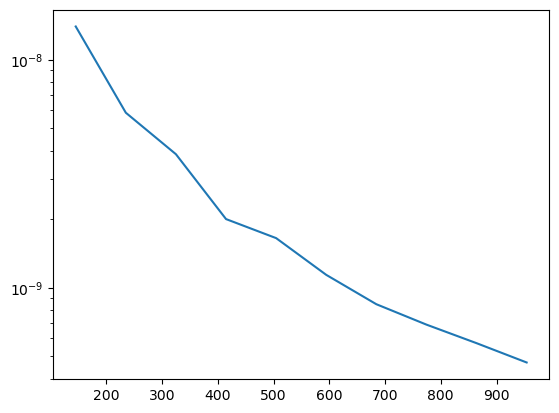

In [6]:
import scipy as sc

lensing_err = abs(cmb_auto_noisey - cmb_auto)
bin_means, bin_edges, binnumber = sc.stats.binned_statistic(ell, lensing_err, statistic='mean', bins=10)

#plt.plot(ell, lensing_err)

bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.plot(bin_centers, bin_means)

plt.yscale('log')